In [1]:
import os
import time
import pandas as pd
import numpy as np

import rasterio

import dask_gateway
import dask.array as da

from joblib import load

import raster_to_features as rm
import data_sampling_workflow.sample_rasters as sr

import planetary_computer as pc
import rioxarray as rioxr
import xarray as xr
import dask.dataframe as daf
import dask.array as da

import math
from affine import Affine

In [2]:
n_workers = 16

In [3]:
# initialize DASK cluster
cluster = dask_gateway.GatewayCluster()
cluster.scale(n_workers)

client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.9fb63dc54e844dd5a3ffcb55431af4de/status,


In [ ]:
# actual_raster = rioxr.open_rasterio(href)
# actual_raster

In [4]:
#scene_ids = pd.read_csv(os.path.join(os.getcwd(),'temp','coastal_scenes_ids_2020.csv')).itemid.loc[19:26]
itemid = 'ca_m_3411934_sw_11_060_20200521' # CAMPUS POINT 2020

# ---------------------------------------
# open NAIP scene
item = sr.get_item_from_id(itemid)   
y_n = item.properties['proj:shape'][0]
x_n = item.properties['proj:shape'][1]

href = pc.sign(item.assets["image"].href)

raster = rioxr.open_rasterio(href, chunks={"x": int(x_n/4), "y":int(y_n/4)})           # open raster as dask array (MAYBE FIGURE OUT BETTER CHUNK SIZES)

raster = raster.drop_vars(['spatial_ref','x','y'])
raster

<xarray.DataArray (band: 4, y: 12500, x: 10580)>
dask.array<open_rasterio-85f0573f706e3f4285b7e6daca7d926d<this-array>, shape=(4, 12500, 10580), dtype=uint8, chunksize=(4, 3125, 2645), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1 2 3 4
Dimensions without coordinates: y, x
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

In [5]:
pixels = daf.from_array(raster.stack(z=("y", "x")).drop_vars('z').T, 
                      chunksize = int(x_n*y_n/n_workers))
pixels = pixels.astype('int16')
#pixels['index'] = da.from_array(np.arange(0,x_n*y_n))
pixels['pix_n'] = daf.from_array(np.arange(0,x_n*y_n), chunksize = int(x_n*y_n/n_workers))
pixels

,0,1,2,3,pix_n
npartitions=16,,,,,
0,int16,int16,int16,int16,int64
8265625,...,...,...,...,...
...,...,...,...,...,...
123984375,...,...,...,...,...
132249999,...,...,...,...,...


In [19]:
pixels.compute()

,0,1,2,3,index
0,204,196,189,175,0
1,208,199,192,181,1
2,183,181,177,160,2
3,167,170,164,140,3
4,166,171,163,139,4
...,...,...,...,...,...
8265620,28,46,59,12,132249995
8265621,27,50,63,13,132249996
8265622,26,47,59,9,132249997
8265623,29,56,60,11,132249998


In [6]:
pixels['ndvi'] = (pixels[3] - pixels[0])/(pixels[3] + pixels[0])
pixels['ndwi'] = (pixels[1] - pixels[3])/(pixels[1] + pixels[3])
pixels

,0,1,2,3,pix_n,ndvi,ndwi
npartitions=16,,,,,,,
0,int16,int16,int16,int16,int64,float64,float64
8265625,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
123984375,...,...,...,...,...,...,...
132249999,...,...,...,...,...,...,...


In [7]:
not_water = pixels[pixels.ndwi < 0.3]
is_veg = not_water[not_water.ndvi > 0.05]

In [22]:
is_veg.compute()

,0,1,2,3,index,ndvi,ndwi
83,79,101,86,147,83,0.300885,-0.185484
84,71,98,73,158,84,0.379913,-0.234375
85,95,118,82,180,85,0.309091,-0.208054
86,105,125,93,188,86,0.283276,-0.201278
87,155,164,138,185,87,0.088235,-0.060172
...,...,...,...,...,...,...,...
7979797,32,49,54,38,131964172,0.085714,0.126437
7990377,33,45,53,39,131974752,0.083333,0.071429
8063329,50,92,76,66,132047704,0.137931,0.164557
8190520,78,121,130,88,132174895,0.060241,0.157895


In [ ]:
24691336   132178596

In [8]:
is_veg_index = is_veg.pix_n

In [10]:
is_veg = is_veg.drop(['ndwi','pix_n'], axis=1)

date = item.datetime
kwargs = {'year' : date.year,
         'month' : date.month,
         'day_in_year' : sr.day_in_year(date.day, date.month, date.year)}

is_veg = is_veg.assign(**kwargs)
is_veg

,0,1,2,3,ndvi,year,month,day_in_year
npartitions=16,,,,,,,,
0,int16,int16,int16,int16,float64,int64,int64,int64
8265625,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
123984375,...,...,...,...,...,...,...,...
132249999,...,...,...,...,...,...,...,...


In [11]:
# open pre-trained random forest classifier
rfc = load('spectral_rfc.joblib') 
print('loaded model')

loaded model


In [12]:
da_pixels = is_veg.to_dask_array()
da_pixels

dask.array<values, shape=(nan, 8), dtype=float64, chunksize=(nan, 8), chunktype=numpy.ndarray>

In [13]:
scene_preds = rfc.predict(da_pixels)
scene_preds

dask.array<_predict, shape=(nan,), dtype=int64, chunksize=(nan,), chunktype=numpy.ndarray>

In [14]:
scene_preds = scene_preds.compute()
scene_preds

array([0, 0, 0, ..., 0, 0, 0])

In [15]:
np.count_nonzero(scene_preds==1)

985004

In [17]:
veg_index = is_veg_index.compute()
veg_index

83                83
84                84
85                85
86                86
87                87
             ...    
7979797    131964172
7990377    131974752
8063329    132047704
8190520    132174895
8194221    132178596
Name: pix_n, Length: 24691336, dtype: int64

In [18]:
preds_df = pd.DataFrame(scene_preds, 
                         columns=['is_iceplant'], 
                         index = veg_index)
is_iceplant_index = preds_df[preds_df.is_iceplant == 1].index.to_numpy()
non_iceplant_index = preds_df[preds_df.is_iceplant == 0].index.to_numpy()

In [19]:
# reconstruct indices into image
indices = [non_iceplant_index,
           is_iceplant_index]
values = [0,    # values assigned to pixels from each index
          1]

In [17]:
# def indices_to_image2(nrows, ncols, indices_list, values, back_value):
#     # background, any pixel not in the union of indices will be given this value
#     reconstruct = np.ones((nrows,ncols))*back_value 

#     # TO DO: check indices list and values lengths are the same?
#     for k in range(0,len(indices_list)):
#         j = indices_list[k] / nrows
#         j = j.astype(int)
#         i = indices_list[k] % nrows
#         reconstruct[i,j] = values[k]
    
#     return reconstruct

# # ***************************************************************************************************
# # def indices_to_image(nrows, ncols, indices_list, values, back_value):
# #     reconstruct = np.ones((nrows,ncols))*back_value 

# #     # TO DO: check indices list and values lengths are the same?
# #     for k in range(0,len(indices_list)):
# #         i = indices_list[k] / ncols
# #         i = i.astype(int)
# #         j = indices_list[k] % ncols
# #         reconstruct[i,j] = values[k]
    
# #     return reconstruct

In [20]:
reconstruct = rm.indices_to_image(y_n,x_n, indices, values, back_value=0)

In [21]:
reconstruct.shape

(12500, 10580)

In [22]:
import matplotlib.pyplot as plt

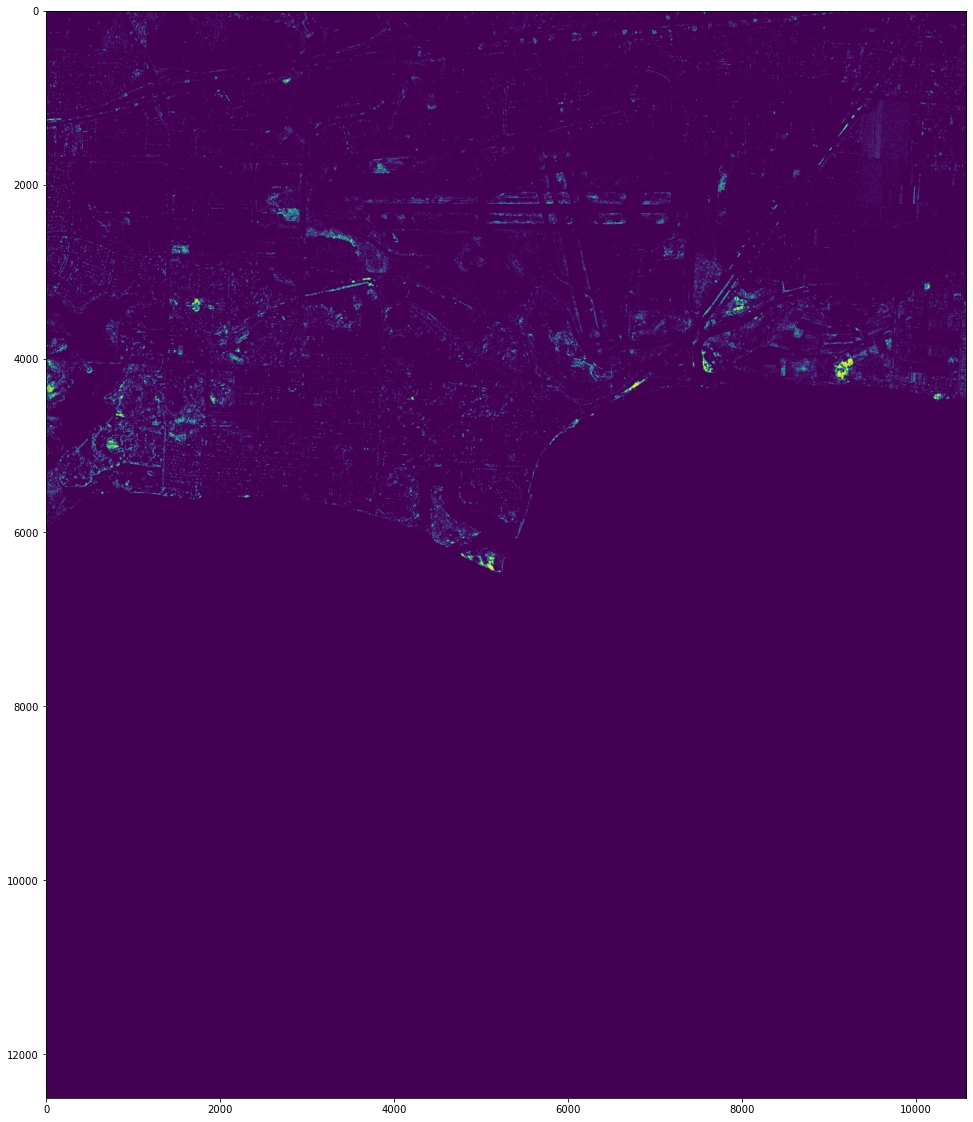

In [23]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(reconstruct)
plt.show()

In [24]:
# ---------------------------------------
# save raster 
filename = 'dask_preds_' + itemid +'.tif'

with rasterio.open(
    os.path.join(os.getcwd(),'temp',filename),  # file path
    'w',           # w = write
    driver = 'GTiff', # format
    height = y_n, 
    width = x_n,
    count = 1,  # number of raster bands in the dataset
    dtype = rasterio.uint8,
    crs = raster.rio.crs,
#    transform = raster.rio.transform(),
    transform = Affine(*item.properties['proj:transform'][0:6]),
) as dst:
    dst.write(reconstruct.T.astype(rasterio.uint8), 1)
# ---------------------------------------
print('FINISHED: ', itemid , '\n')

FINISHED:  ca_m_3411934_sw_11_060_20200521 

